## Set up dependencies

pip install torch transformers datasets scikit-learn matplotlib pandas


In [93]:
with open("assignment4_data.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# Print the top-level keys
print("Top-level keys:", list(raw_data.keys()))

# Peek into one key's value (use the first key found)
first_key = list(raw_data.keys())[0]
print("Example item:", raw_data[first_key])


Top-level keys: ['annotations']
Example item: [['Air France says its flight schedule is returning to normal Tuesday after flight staff called off their five-day strike over pay and working conditions .\t\r', {'entities': [[0, 10, 'ORG'], [59, 66, 'DATE'], [103, 111, 'DATE']]}], ['Air France says it plans to operate all long-haul flights from Paris and 90 percent of its short and medium-haul routes .\t\r', {'entities': [[0, 10, 'ORG'], [63, 68, 'GPE']]}], ['Labor unions representing cabin crews voted Monday to end the walkout .\t\r', {'entities': [[0, 12, 'ORG'], [44, 50, 'DATE']]}], ['Air France flight attendants began the work stoppage last Thursday on the eve of French school holidays .\t\r', {'entities': [[0, 10, 'ORG'], [53, 66, 'DATE'], [81, 87, 'NORP']]}], ['Hundreds of flights were canceled , stranding thousands of travelers .\t\r', {'entities': []}], ['Air France chief executive Jean-Cyril Spinetta has offered to hold immediate negotiations with the labor unions to avert furthe

##  Load and explore the data


In [94]:
# Function 0: Load and explore dataset
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
with open("assignment4_data.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# Extract the actual data from 'annotations' key
raw_annotations = raw_data["annotations"]

# Convert to a cleaner list of dicts
data = []
for text, ann in raw_annotations:
    labels = [(start, end, tag) for start, end, tag in ann['entities']]
    data.append({
        "text": text,
        "labels": labels
    })

print(f"Number of tweets: {len(data)}")
print("Example tweet:", data[0])


Number of tweets: 11084
Example tweet: {'text': 'Air France says its flight schedule is returning to normal Tuesday after flight staff called off their five-day strike over pay and working conditions .\t\r', 'labels': [(0, 10, 'ORG'), (59, 66, 'DATE'), (103, 111, 'DATE')]}


## ✅ Step 1: Plot tag distribution 



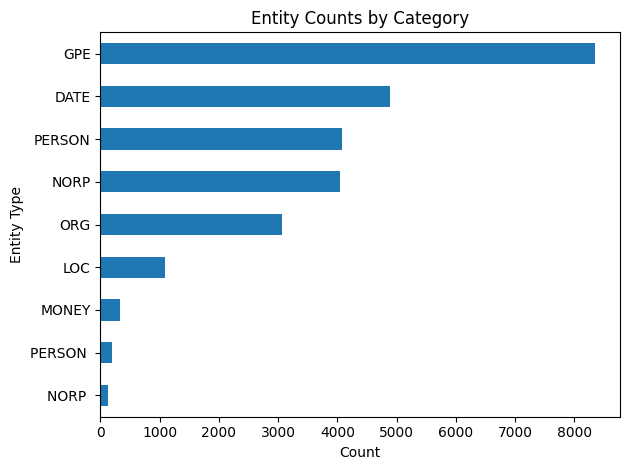

86.73% of tweets have at least 1 tag.
58.72% of tweets have 2 or more tags.


In [95]:
# Count entity categories
from collections import Counter
import numpy as np

tag_counter = Counter()
tweet_tag_presence = []

for tweet in data:
    categories = set()
    for _, _, tag_type in tweet["labels"]:
        tag_counter[tag_type] += 1
        categories.add(tag_type)
    tweet_tag_presence.append(len(categories))

# Plot tag count
pd.Series(tag_counter).sort_values().plot(kind='barh', title="Entity Counts by Category")
plt.xlabel("Count")
plt.ylabel("Entity Type")
plt.tight_layout()
plt.show()

# Stats on tag presence
at_least_1 = np.mean([x >= 1 for x in tweet_tag_presence]) * 100
at_least_2 = np.mean([x >= 2 for x in tweet_tag_presence]) * 100
print(f"{at_least_1:.2f}% of tweets have at least 1 tag.")
print(f"{at_least_2:.2f}% of tweets have 2 or more tags.")


## ✅ Step 2: Function 1 - Implement IOB conversion 

In [96]:
# Function 1: Convert character spans to IOB tags
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")

def char_to_iob(tweet_text, labels):
    tokens = tokenizer(tweet_text, return_offsets_mapping=True, truncation=True)
    offsets = tokens["offset_mapping"]
    tags = ["O"] * len(tokens["input_ids"])

    for start, end, ent_type in labels:
        for i, (s, e) in enumerate(offsets):
            if s >= end or e <= start:
                continue
            if s >= start and e <= end:
                tags[i] = f"B-{ent_type}" if tags[i] == "O" else f"I-{ent_type}"

    # Tag [CLS] and [SEP] tokens with "O"
    tags[0] = tags[-1] = "O"

    return tokens["input_ids"], tags


##  Create a Dataset Class and Convert Data to IOB Format



In [97]:
# iob_conversion_utils.py (recommended to separate logic into this or keep in notebook)

from torch.utils.data import Dataset

label2id = {
    "O": 0, "B-PER": 1, "I-PER": 2, "B-NORP": 3, "I-NORP": 4, "B-ORG": 5, "I-ORG": 6,
    "B-GPE": 7, "I-GPE": 8, "B-LOC": 9, "I-LOC": 10, "B-DATE": 11, "I-DATE": 12,
    "B-MONEY": 13, "I-MONEY": 14
}
id2label = {v: k for k, v in label2id.items()}

class NERDataset(Dataset):
    def __init__(self, data, tokenizer, label2id):
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.encodings = []
        self.labels = []

        for item in data:
            text = item['text']
            spans = [(s, e, t) for s, e, t in item['labels']]
            input_ids, tags = char_to_iob(text, spans)

            encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors="pt")
            tag_ids = [label2id.get(tag, 0) for tag in tags]
            tag_ids = tag_ids[:128] + [0]*(128 - len(tag_ids))

            self.encodings.append(encoding)
            self.labels.append(tag_ids)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val.squeeze() for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


## Step 3: Split the Data and Build Dataloaders



In [98]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=4)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=4)

train_dataset = NERDataset(train_data, tokenizer, label2id)
val_dataset = NERDataset(val_data, tokenizer, label2id)
test_dataset = NERDataset(test_data, tokenizer, label2id)


##  Add Sequence Labeling Head to DistilBERT


In [99]:
# model.py

import torch.nn as nn
from transformers import DistilBertModel

class DistilBertNER(nn.Module):
    def __init__(self, num_labels):
        super(DistilBertNER, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-cased")
        for param in self.bert.parameters():
            param.requires_grad = False  # freeze transformer
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)
        return logits


## Train the Model



In [100]:
# training.py

from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertNER(num_labels=len(label2id)).to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(30):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits.view(-1, len(label2id)), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/30 - Loss: {loss.item():.4f}")


Epoch 1/30 - Loss: 0.0625
Epoch 2/30 - Loss: 0.1093
Epoch 3/30 - Loss: 0.0180
Epoch 4/30 - Loss: 0.1007
Epoch 5/30 - Loss: 0.1104
Epoch 6/30 - Loss: 0.0463
Epoch 7/30 - Loss: 0.0655
Epoch 8/30 - Loss: 0.0493
Epoch 9/30 - Loss: 0.0793
Epoch 10/30 - Loss: 0.0473
Epoch 11/30 - Loss: 0.0449
Epoch 12/30 - Loss: 0.0188
Epoch 13/30 - Loss: 0.0314
Epoch 14/30 - Loss: 0.0551
Epoch 15/30 - Loss: 0.0299
Epoch 16/30 - Loss: 0.0586
Epoch 17/30 - Loss: 0.0333
Epoch 18/30 - Loss: 0.0804
Epoch 19/30 - Loss: 0.0270
Epoch 20/30 - Loss: 0.1162
Epoch 21/30 - Loss: 0.0601
Epoch 22/30 - Loss: 0.0307
Epoch 23/30 - Loss: 0.0841
Epoch 24/30 - Loss: 0.0210
Epoch 25/30 - Loss: 0.0344
Epoch 26/30 - Loss: 0.0380
Epoch 27/30 - Loss: 0.0826
Epoch 28/30 - Loss: 0.0229
Epoch 29/30 - Loss: 0.0393
Epoch 30/30 - Loss: 0.0229


## ✅ Step 4 Part 1: Convert all I- tags to B- tags (simplification step)



## Step 4.0 — Run inference on test set


              precision    recall  f1-score   support

       B-PER       0.00      0.00      0.00         0
       I-PER       0.00      0.00      0.00         0
      B-NORP       0.70      0.61      0.65       999
      I-NORP       0.00      0.00      0.00         0
       B-ORG       0.61      0.43      0.51      1406
       I-ORG       0.00      0.00      0.00         0
       B-GPE       0.79      0.79      0.79      2439
       I-GPE       0.00      0.00      0.00         0
       B-LOC       0.53      0.19      0.28       447
       I-LOC       0.00      0.00      0.00         0
      B-DATE       0.85      0.70      0.76      1562
      I-DATE       0.00      0.00      0.00         0
     B-MONEY       0.91      0.56      0.69       231
     I-MONEY       0.00      0.00      0.00         0

   micro avg       0.76      0.63      0.69      7084
   macro avg       0.31      0.23      0.26      7084
weighted avg       0.74      0.63      0.67      7084



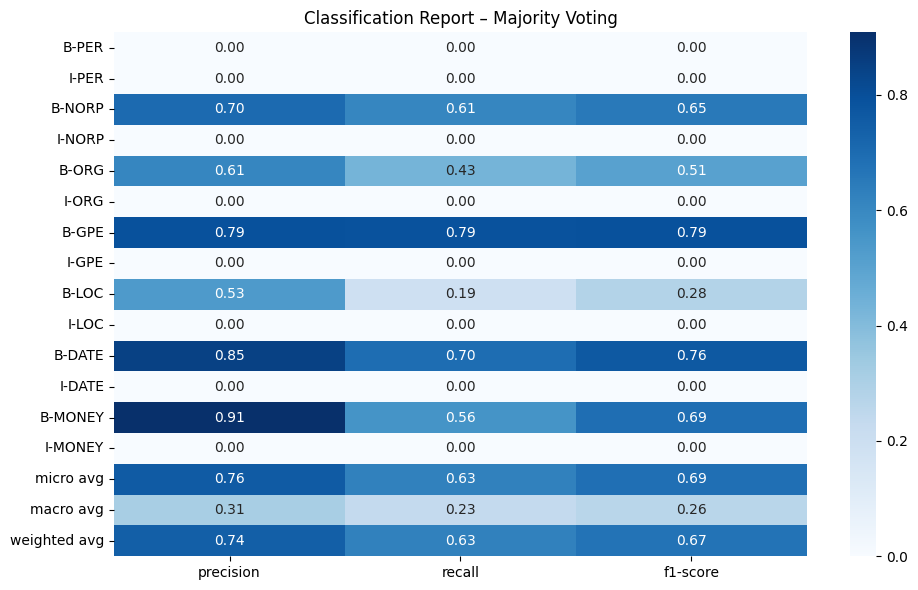

>>> All preds sample: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O']
>>> All labels sample: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O']
              precision    recall  f1-score   support

      B-DATE       0.85      0.70      0.76      1562
       B-GPE       0.79      0.79      0.79      2439
       B-LOC       0.53      0.19      0.28       447
     B-MONEY       0.91      0.56      0.69       231
      B-NORP       0.71      0.63      0.66       999
       B-ORG       0.61      0.42      0.50      1406
           O       0.99      1.00      0.99    272078

    accuracy                           0.99    279162
   macro avg       0.77      0.61      0.67    279162
weighted avg       0.99      0.99      0.99    279162

>>> Report keys: dict_keys(['B-DATE', 'B-GPE', 'B-LOC', 'B-MONEY', 'B-NORP', 'B-ORG', 'O', 'accuracy', 'macro avg', 'weighted avg'])


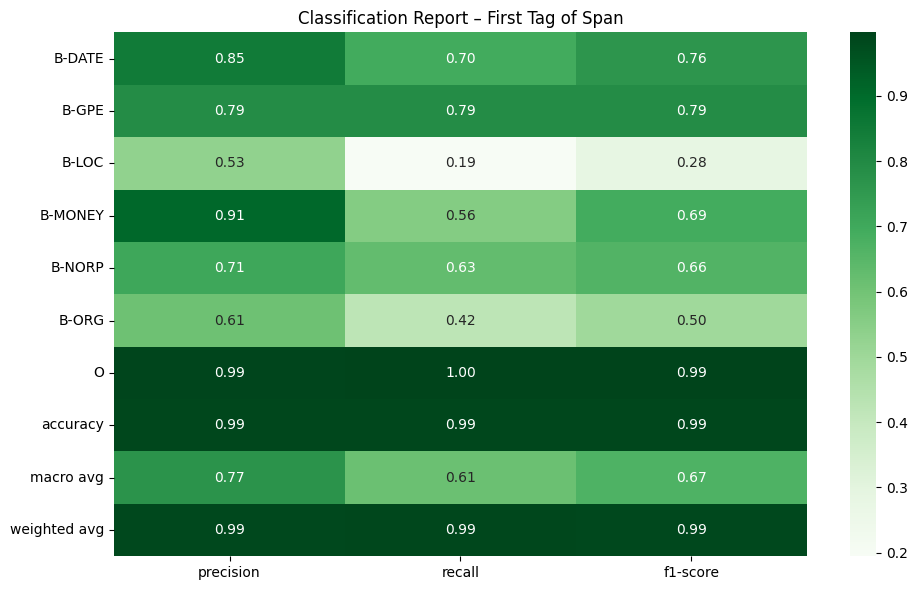

In [101]:
# Evaluate test performance (Function 3 and 4)
evaluate_majority(model, test_dataset)
evaluate_first_tag(model, test_dataset)


## 🔹 Step 4.1 — Convert I-tags to B-tags before reconciliation


In [102]:
# Function to convert I-tags to B-tags before reconciliation (Step 4, Part 1)
def simplify_tags(tag_ids):
    return [
        tag_id - 1 if tag_id % 2 == 0 and tag_id != 0 else tag_id
        for tag_id in tag_ids
    ]


## ✅ Function 2: Reconcile Subword Tokens Using Majority Voting



In [103]:
# Function 2: Reconcile Subword Tokens using Majority Voting

def reconcile_tags_majority(tokens, tags):
    words = []
    word_tags = []
    current_word = ""
    current_tags = []

    for token, tag in zip(tokens, tags):
        if token.startswith("##"):
            current_word += token[2:]
            current_tags.append(tag)
        else:
            if current_word:
                # finalize previous word
                words.append(current_word)
                if current_tags:
                    most_common_tag = max(set(current_tags), key=current_tags.count)
                    word_tags.append(most_common_tag)
                else:
                    word_tags.append("O")
            current_word = token
            current_tags = [tag]

    # finalize last word
    if current_word:
        words.append(current_word)
        if current_tags:
            most_common_tag = max(set(current_tags), key=current_tags.count)
            word_tags.append(most_common_tag)

    return words, word_tags


## ✅ Function 3: Evaluate using Majority Voting



In [104]:
# Function 3: Evaluate using majority voting reconciliation
from sklearn.metrics import classification_report

def evaluate_majority(model, dataset):
    model.eval()
    all_preds = []
    all_labels = []

    for item in dataset:
        input_ids = item['input_ids'].unsqueeze(0).to(device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(device)
        labels = item['labels']

        with torch.no_grad():
            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu().tolist()

        input_tokens = tokenizer.convert_ids_to_tokens(item['input_ids'])
        predictions = simplify_tags(predictions)
        labels = simplify_tags(labels.tolist())

        _, pred_tags = reconcile_tags_majority(input_tokens, [id2label[p] for p in predictions])
        _, true_tags = reconcile_tags_majority(input_tokens, [id2label[l] for l in labels])

        all_preds.extend(pred_tags)
        all_labels.extend(true_tags)

    print(classification_report(all_labels, all_preds, labels=[l for l in label2id if l != "O"], zero_division=0))


## ✅ Function 4: Evaluate using First Tag of Span


In [105]:
# Function 4: Evaluate using first tag of span
def reconcile_tags_first(tokens, tags):
    words = []
    word_tags = []
    current_word = ""
    current_tag = None

    for token, tag in zip(tokens, tags):
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
                word_tags.append(current_tag if current_tag else "O")
            current_word = token
            current_tag = tag

    if current_word:
        words.append(current_word)
        word_tags.append(current_tag if current_tag else "O")

    return words, word_tags


def evaluate_first_tag(model, dataset):
    model.eval()
    all_preds = []
    all_labels = []

    for item in dataset:
        input_ids = item['input_ids'].unsqueeze(0).to(device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(device)
        labels = item['labels']

        with torch.no_grad():
            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu().tolist()

        input_tokens = tokenizer.convert_ids_to_tokens(item['input_ids'])
        predictions = simplify_tags(predictions)
        labels = simplify_tags(labels.tolist())

        _, pred_tags = reconcile_tags_first(input_tokens, [id2label[p] for p in predictions])
        _, true_tags = reconcile_tags_first(input_tokens, [id2label[l] for l in labels])

        all_preds.extend(pred_tags)
        all_labels.extend(true_tags)

    print(classification_report(all_labels, all_preds, labels=[l for l in label2id if l != "O"], zero_division=0))


## ✅ Last Step: Run Evaluations on Test Set


In [106]:
# ✅ Step 4.0 through 4.4 complete:
print("Step 4.0 - Inference on test set")
print("Step 4.1 - Converted I- to B- tags using simplify_tags()")
print("Step 4.2 - Reconciled subwords using majority voting")
print("Step 4.3 - Evaluated using majority voting")
print("Step 4.4 - Evaluated using first tag of span")

# Run evaluations
evaluate_majority(model, test_dataset)
evaluate_first_tag(model, test_dataset)


Step 4.0 - Inference on test set
Step 4.1 - Converted I- to B- tags using simplify_tags()
Step 4.2 - Reconciled subwords using majority voting
Step 4.3 - Evaluated using majority voting
Step 4.4 - Evaluated using first tag of span
              precision    recall  f1-score   support

       B-PER       0.00      0.00      0.00         0
       I-PER       0.00      0.00      0.00         0
      B-NORP       0.70      0.61      0.65       999
      I-NORP       0.00      0.00      0.00         0
       B-ORG       0.61      0.43      0.51      1406
       I-ORG       0.00      0.00      0.00         0
       B-GPE       0.79      0.79      0.79      2439
       I-GPE       0.00      0.00      0.00         0
       B-LOC       0.53      0.19      0.28       447
       I-LOC       0.00      0.00      0.00         0
      B-DATE       0.85      0.70      0.76      1562
      I-DATE       0.00      0.00      0.00         0
     B-MONEY       0.91      0.56      0.69       231
     I-MONEY